### Functions and Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import random as r
from keras.optimizers import Adam
import SimpleITK as sitk
import glob

from keras.models import Input, Model
from keras.layers import Conv3D, Concatenate, MaxPooling3D, Reshape
from keras.layers import UpSampling3D, Activation, Permute

from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D, Reshape
from keras.layers import UpSampling2D, Activation, Permute

import keras.backend as K

from sklearn.feature_extraction import image

In [24]:
def create_data(src, label=False, resize=(128,128,155)):
    files = glob.glob(src)
    imgs = []
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        if label:
            img[img == 4] = 1
            img[img != 1] = 0
            img = img.astype('float32')
        else:
            img = (img-img.mean()) / img.std()
        img = trans.resize(img, resize, mode='constant')
        imgs.append(img)
    name = 'y' if label else 'x'
    np.save(name, np.array(imgs)[..., np.newaxis].astype('float32'))
    print('Saved '+ str(len(files)) + ' to '+ name)

In [4]:
def level_block(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv2D(dim, 2, activation=acti, padding='same')(m)
        n = Conv2D(dim, 2, activation=acti, padding='same')(n)
        m = MaxPooling2D()(n)
        m = level_block(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling2D()(m)
        m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, 3, activation=acti, padding='same')(m)
    return Conv2D(dim, 3, activation=acti, padding='same')(m)

def UNet(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='relu', flatten=False):
    i = Input(shape=img_shape)
    o = level_block(i, dim, depth, factor, acti)
    o = Conv2D(n_out, (1, 1))(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    o = Activation('sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [5]:
def level_block_3d(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv3D(dim, 3, activation=acti, padding='same')(m)
        m = MaxPooling3D()(n)
        m = level_block_3d(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling3D()(m)
        m = Concatenate(axis=4)([n, m])
    return Conv3D(dim, 3, activation=acti, padding='same')(m)

def UNet_3D(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='relu'):
    i = Input(shape=img_shape)
    o = level_block_3d(i, dim, depth, factor, acti)
    o = Conv3D(n_out, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [6]:
def f1_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def f1_loss(y_true, y_pred):
    return -f1_score(y_true, y_pred)

In [7]:
def getTumorIndex(ittr,y):
    temp = []
    for px in range(0,y.shape[1]):
        temp.append(y[ittr,px,:,:,0].mean())

    return temp.index(max(temp))

In [8]:
def getMaxPred(p,img3d):
    arr = []
    #count = 0
    for a in range(0,img3d.shape[1]):
        #arr.append(count)
        count = 0
        for b in range(0,img3d.shape[1]):
            for c in range(0,img3d.shape[1]):
                if img3d[p,a,b,c,0] > 0.0004:
                    count+=1
        arr.append(count)
    return max(arr)

In [9]:
def getMaxPredAll(img3d):
    arr = [0]
    arr2 = []
    count = 0
    for z in range(0,img3d.shape[0]):
        arr2.append(getMaxPred(z,img3d))  
    return arr2

### Import Data

In [10]:
from pytictoc import TicToc
timer = TicToc()

In [25]:
timer.tic()
create_data('BRATS2013/*/*T1c*/*T1c*.mha', label=False, resize = (32,32,32))
create_data('BRATS2013/*/*OT*/*OT*.mha', label=True, resize = (32,32,32))
timer.toc()

Saved 20 to x
Saved 20 to y
Elapsed time is 10.345291 seconds.


In [12]:
x = np.load('x.npy')
print('x: '+ str(x.shape))
y = np.load('y.npy')
print('y: '+ str(y.shape))

x: (20, 32, 32, 32, 1)
y: (20, 32, 32, 32, 1)


### Display Data

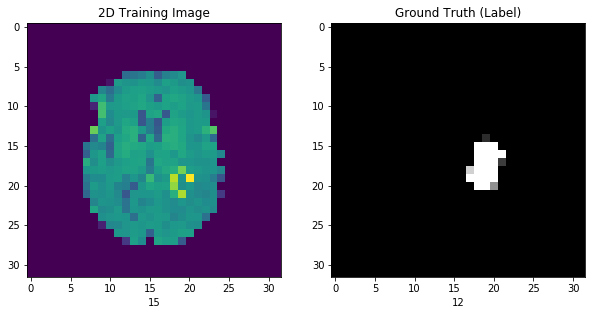

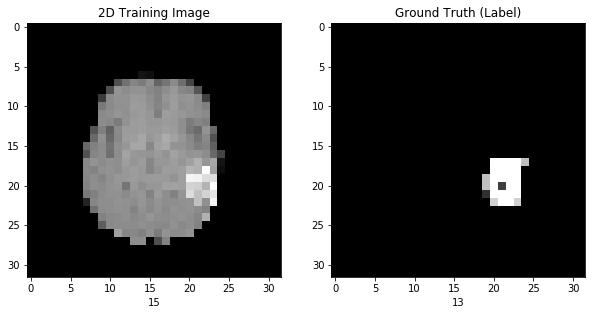

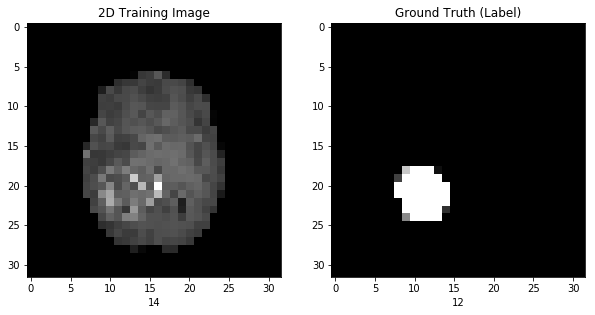

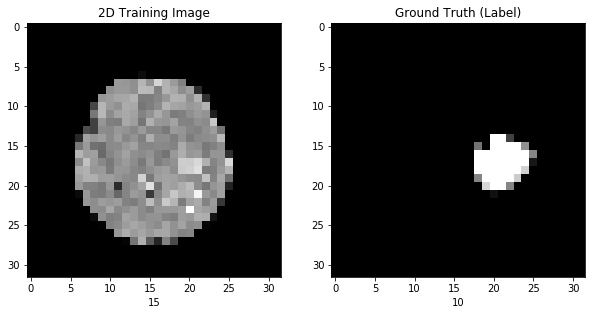

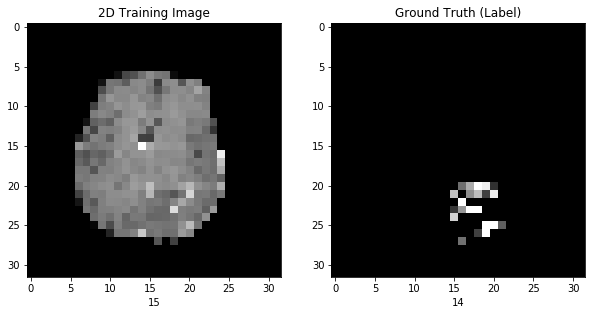

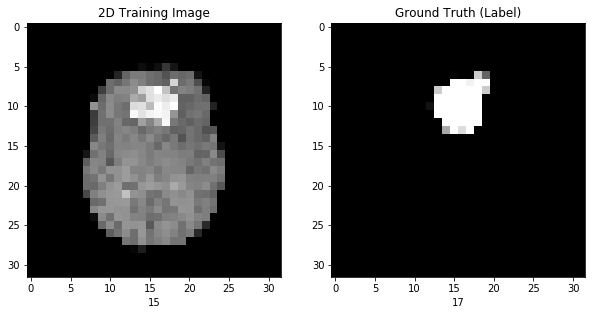

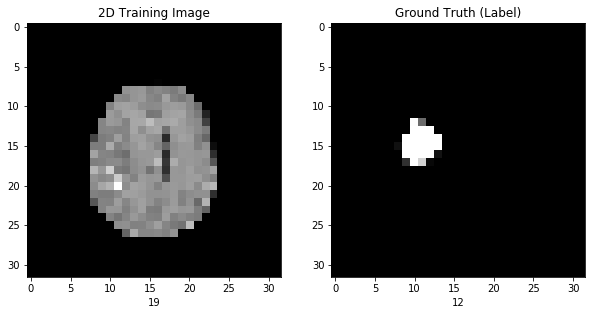

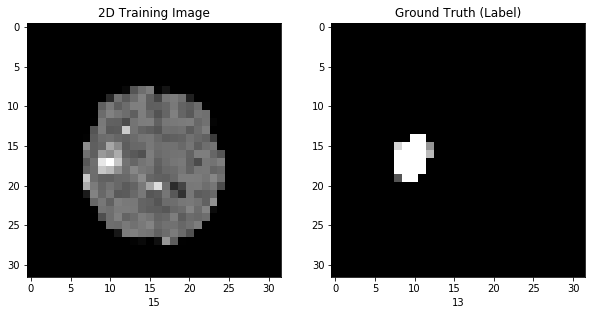

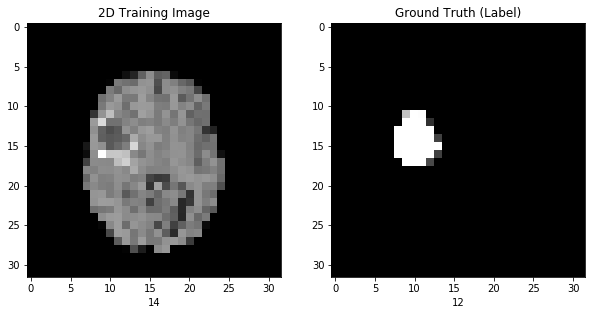

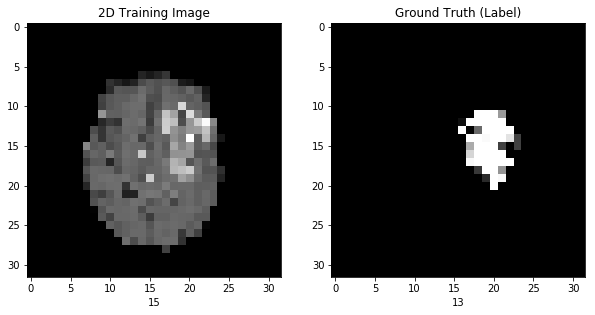

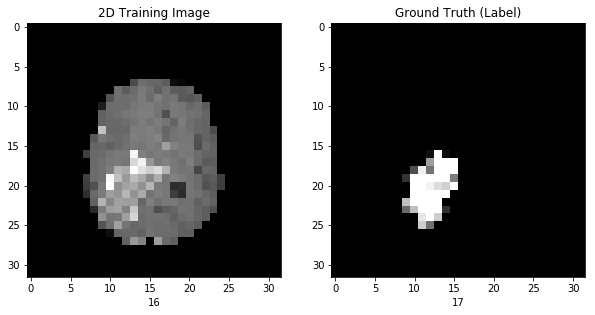

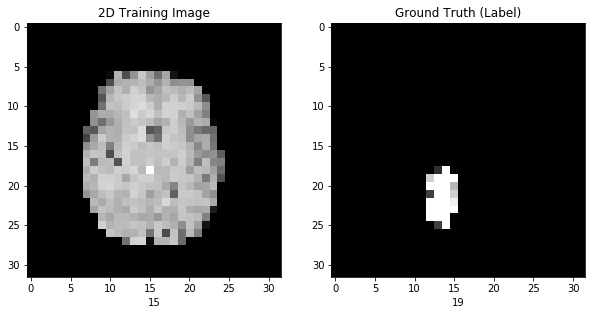

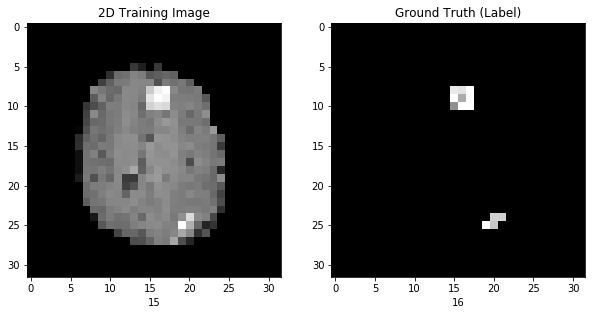

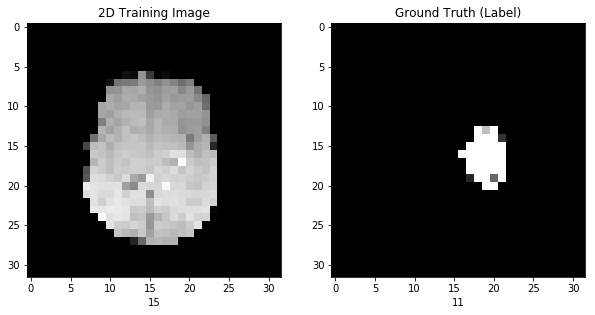

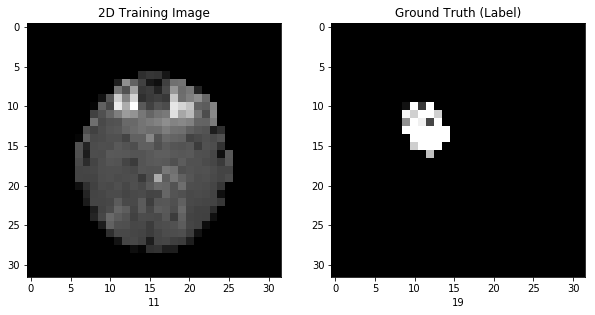

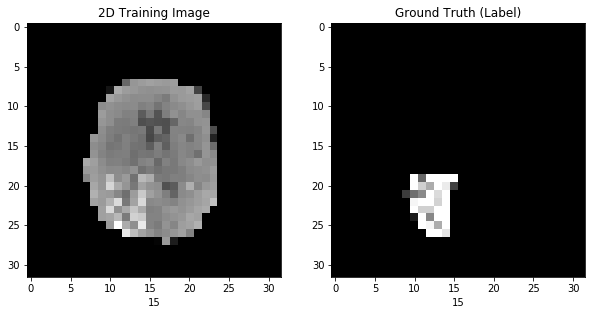

In [13]:
i = int(r.random() * x.shape[0])

for i in range(0,16):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(x[i, getTumorIndex(i,x), :, :, 0])
    plt.xlabel(getTumorIndex(i,x))
    plt.title('2D Training Image')
    plt.subplot(122)
    plt.imshow(y[i, getTumorIndex(i,y), :, :, 0])
    plt.title('Ground Truth (Label)')
    plt.xlabel(getTumorIndex(i,y))
    plt.set_cmap('gray')
    plt.show()

In [19]:
x.shape

(20, 32, 32, 32, 1)

### Training

In [60]:
model = UNet_3D(x.shape[1:], dim=16, factor=1)

In [61]:
model.load_weights('weights.h5')

In [54]:
model.compile(optimizer=Adam(lr=0.000001), loss=f1_loss, metrics = ['accuracy'])

In [37]:
model.fit(x, y, validation_split=0.2, epochs=1, batch_size=4, shuffle = False)

Train on 16 samples, validate on 4 samples
Epoch 1/1
16/16 [==============================] - 152s - loss: -0.5519 - acc: 0.9949 - val_loss: -0.5601 - val_acc: 0.9964


In [55]:
all_weights = []
for layer in model.layers:
   w = layer.get_weights()
   all_weights.append(w)

all_weights = np.array(all_weights)
np.save('all_weights.npy', all_weights)

In [17]:
#model.save_weights('weights.h5')

In [18]:
#model.layers[1].get_weights()

In [26]:
pred = model.predict(x)

In [20]:
#pred = pred.astype('int16')

In [73]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

0


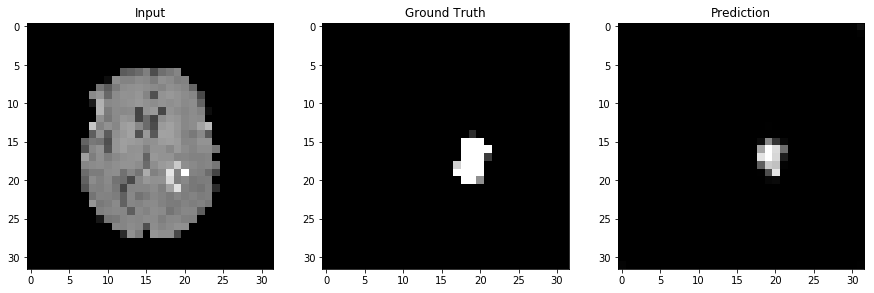

1


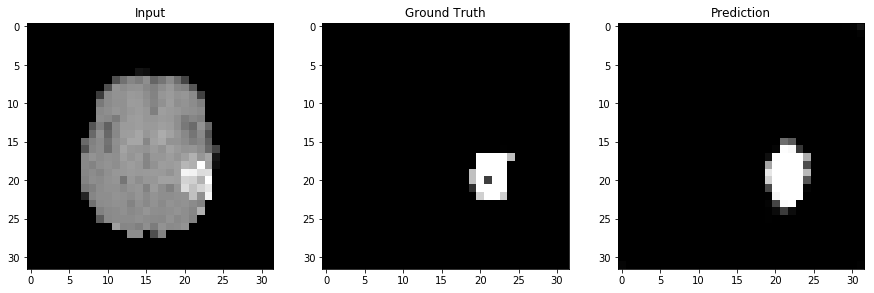

2


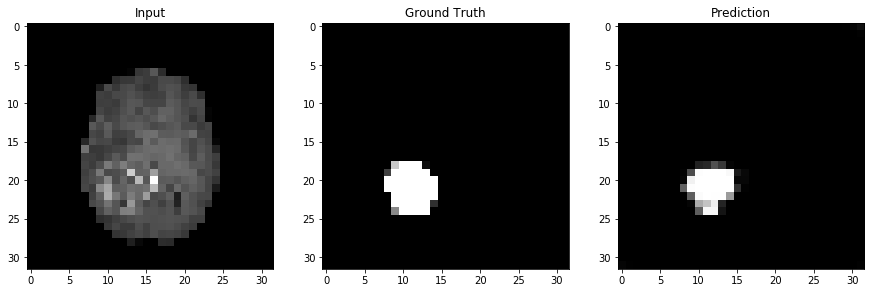

3


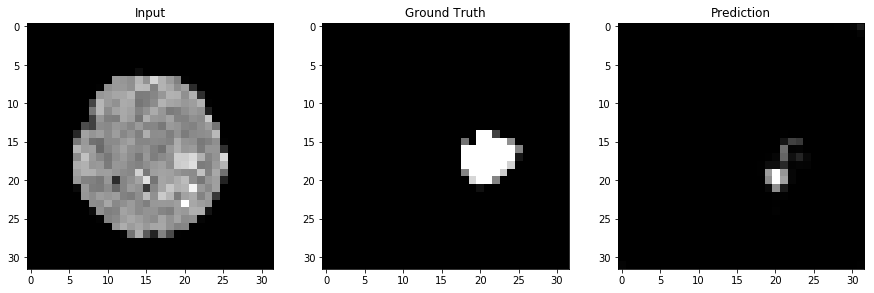

4


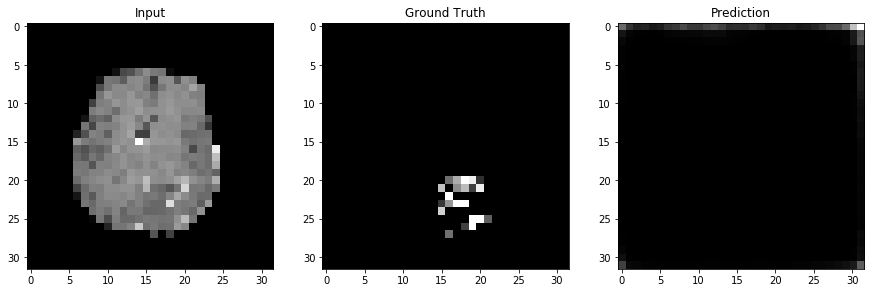

5


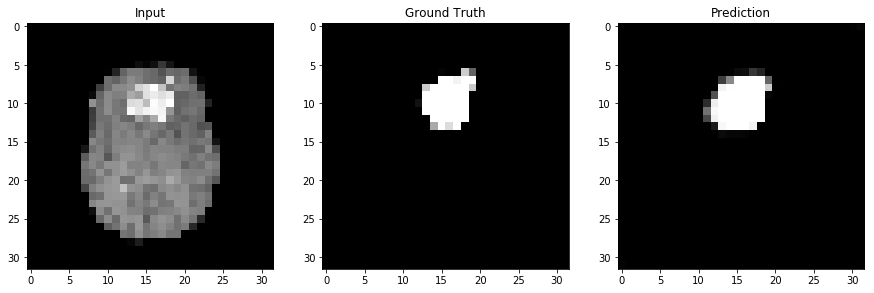

6


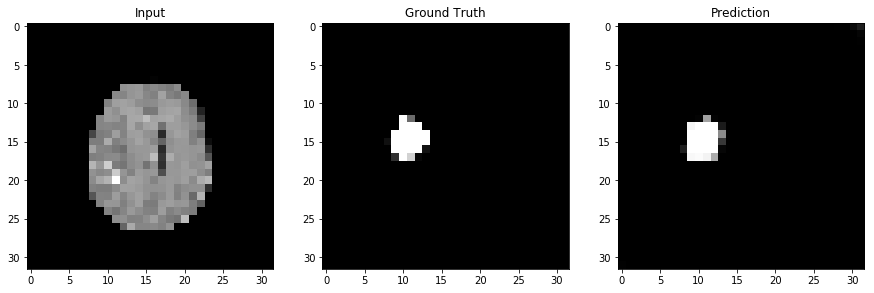

7


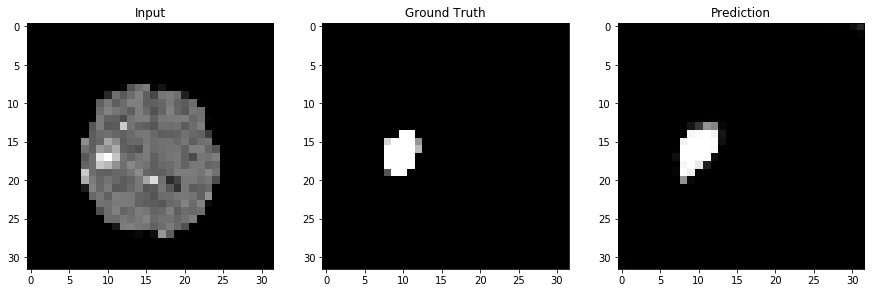

8


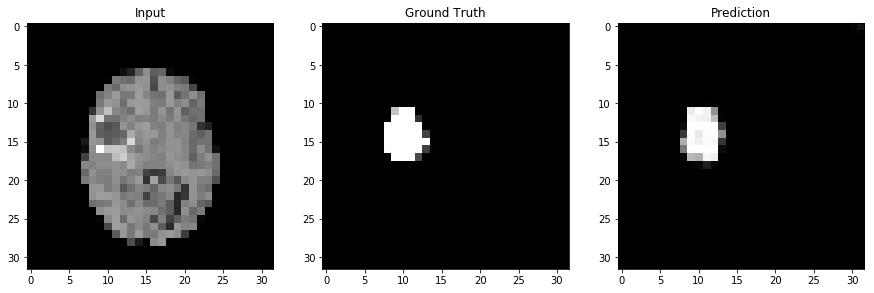

9


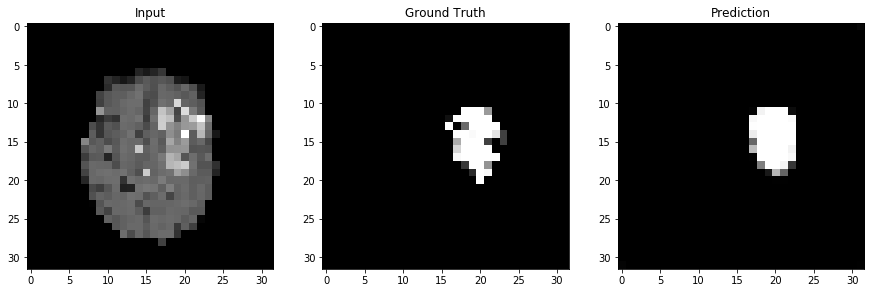

10


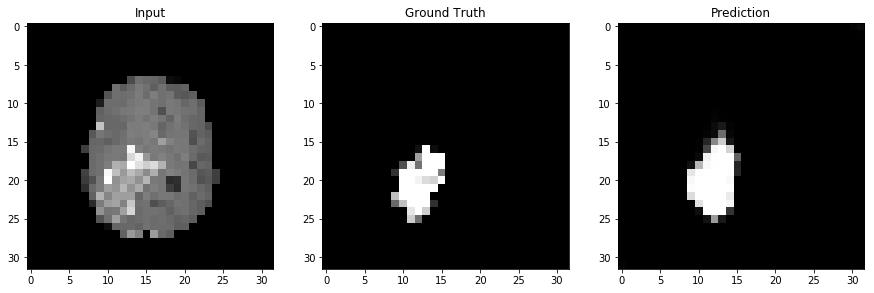

11


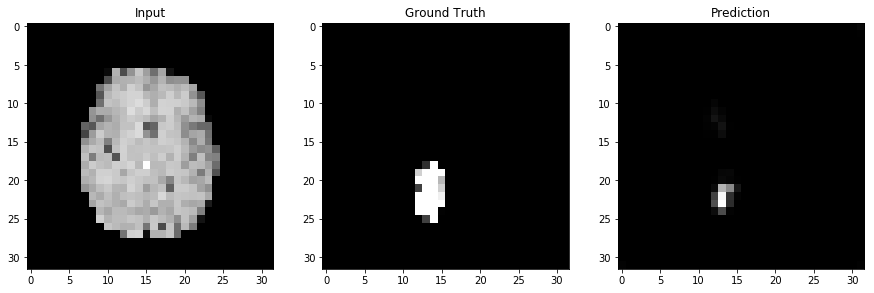

12


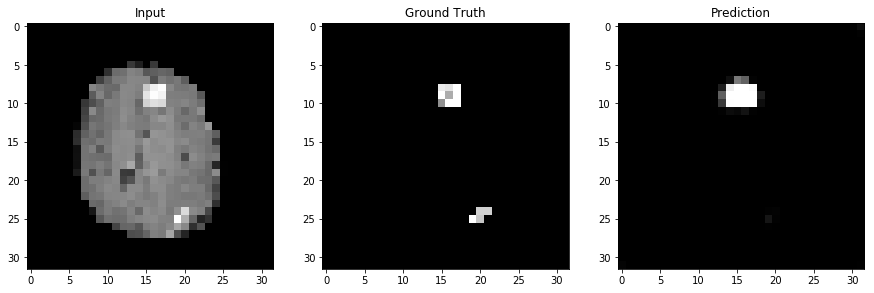

13


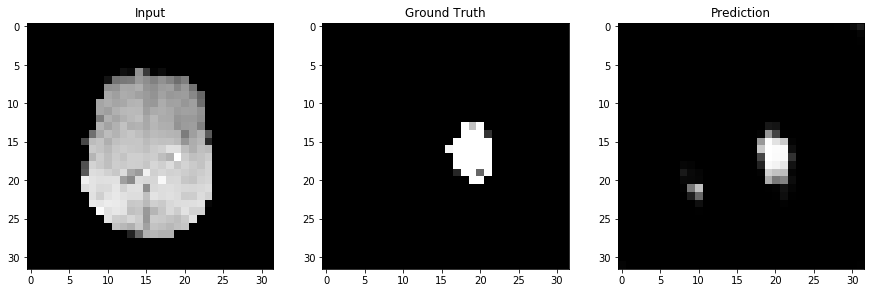

14


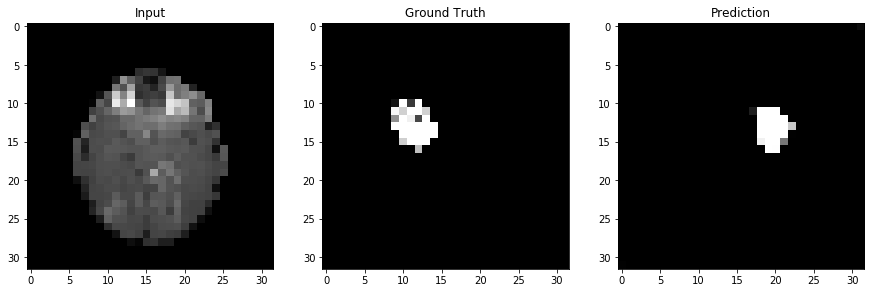

15


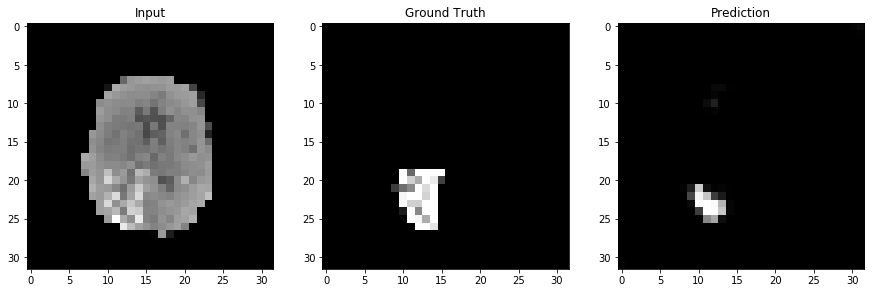

16


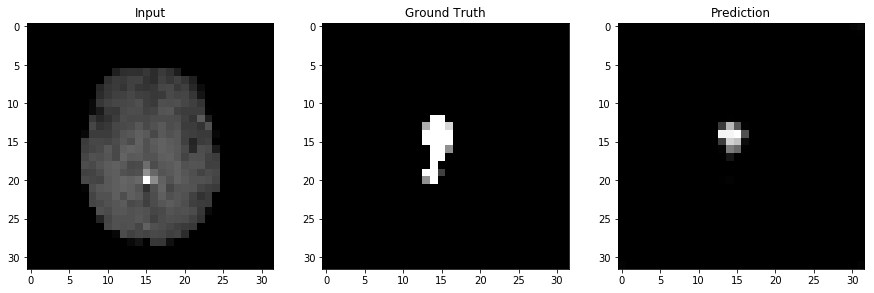

17


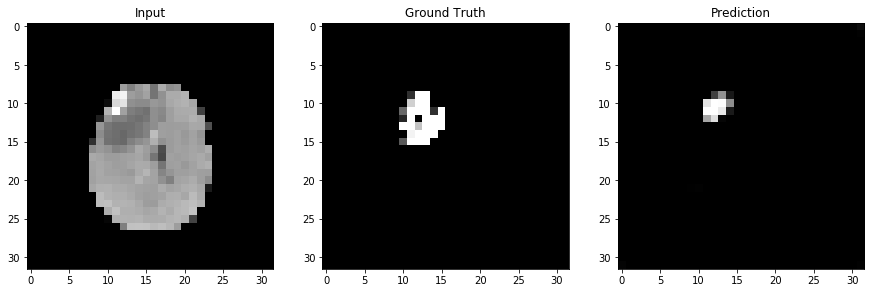

18


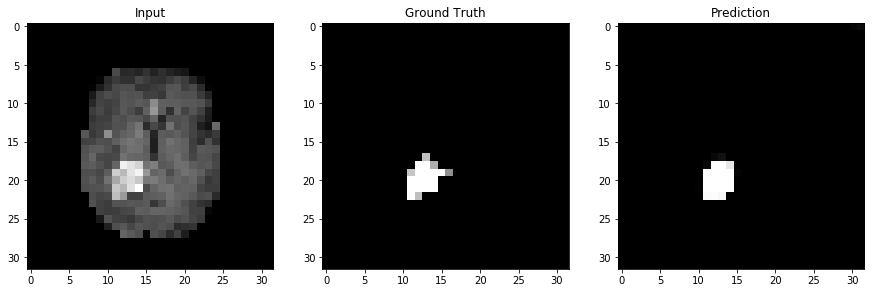

19


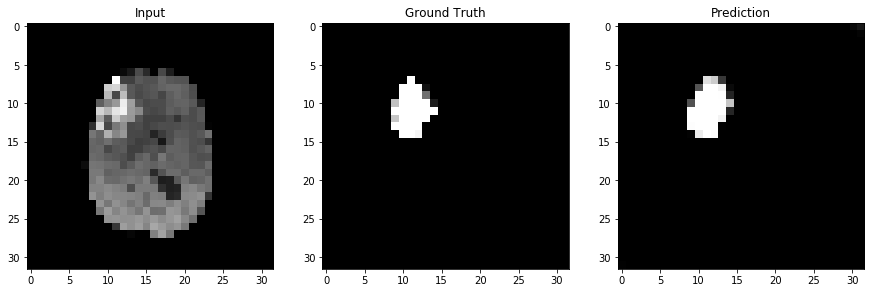

In [27]:
for i in range(0,20):
    plt.figure(figsize=(15,10))
    plt.subplot(131)
    plt.title('Input')
    plt.imshow(x[i, getTumorIndex(i,x), :, :, 0])

    plt.subplot(132)
    plt.title('Ground Truth')
    plt.imshow(y[i, getTumorIndex(i,y), :, :, 0])

    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(pred[i, getTumorIndex(i,pred), :, :, 0])
    plt.set_cmap('gray')
    
    print(i)
    plt.show()

### Analysis and Results

In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 32, 1) 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 32, 32, 32, 16 448         input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)   (None, 16, 16, 16, 16 0           conv3d_1[0][0]                   
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 16, 16, 16, 16 6928        max_pooling3d_1[0][0]            
___________________________________________________________________________________________

In [23]:
#import pydot,graphviz

#keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

/Users/balaram_remala/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


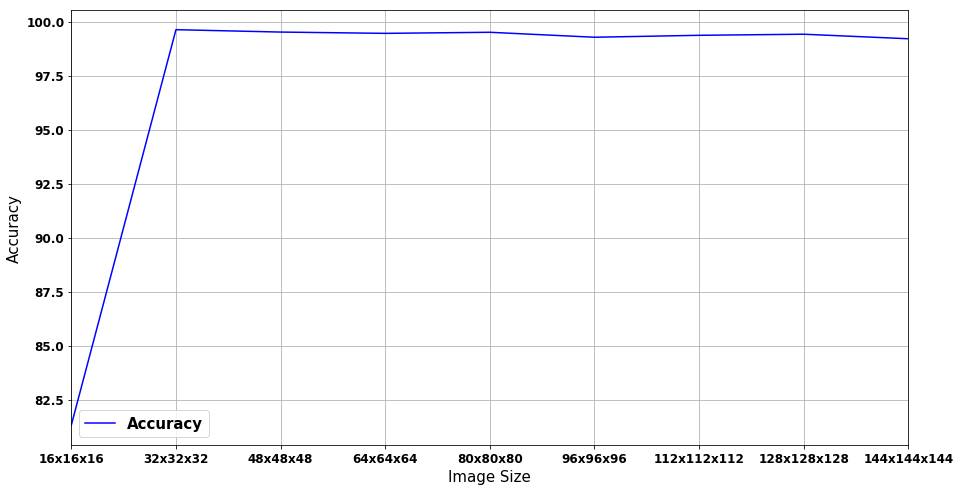

In [24]:
plt.figure()

Imag_acc = pd.read_csv('result1.csv')
Kernel_acc = pd.read_csv('result2.csv')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
Imag_acc.plot(x = 'Image Size', figsize=(15,8), fontsize = 12, grid = True, c = 'b', legend =True)
plt.ylabel('Accuracy')
#Kernel_acc.plot(x = 'Kernel Size', figsize=(10,5), fontsize = 10)
#plt.ylabel('Accuracy')
plt.show()

#### Accuracy Check

In [25]:
import numpy as np


def dice(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())


In [26]:
pred[10, getTumorIndex(10,y), :, :, 0].min()

9.4148492e-27

In [27]:
dice(y[10, getTumorIndex(10,y), :, :, 0],y[3, getTumorIndex(3,pred), :, :, 0])

0.0

### Trail and Error

In [28]:
format(pd.DataFrame.from_records(pred[12,18])[16].max()[0],'.4f')

'0.0009'

In [29]:
q = getMaxPredAll(y)

In [30]:
p = getMaxPredAll(pred)

In [31]:
array = []
for u in range(0,y.shape[0]):
    if (q[u]*2)>p[u]:
        array.append(u)

### Decision Tree Implementation

In [32]:
from sklearn import tree

DT = tree.DecisionTreeClassifier()

DT.fit(input_train_data[features], input_train_label)

NameError: name 'input_train_data' is not defined

In [ ]:
predic = DT.predict(input_test_data[features])

In [ ]:
pd.crosstab(input_test_label, predic, rownames=['Actual Labels'], colnames=['Predicted Labels'])

In [ ]:
#pd.DataFrame.from_records(x[11,19])

In [ ]:
import glob

files = glob.glob("BRATS2013/*/*T1c*/*T1c*.mha")

files[0]

In [ ]:
import SimpleITK as sitk

import matplotlib.pyplot as plt

path = files[4]

fixed_image =  sitk.ReadImage(path,sitk.sitkUInt16)

#plt.figure(figsize=(3.34,3.34))
image_2d = sitk.GetArrayViewFromImage(fixed_image)[80]
plt.imshow(image_2d)
plt.axis('off')
plt.savefig('pat5input.png')
plt.show()

In [ ]:
import pandas as pd

#pd.DataFrame.from_records(image_2d).to_csv()

In [ ]:
#pd.DataFrame.from_records(image_2d.astype('uint8')).to_csv()

plt.imshow(image_2d)
plt.axis('off')
plt.savefig('pat5input.png')
plt.show()


In [ ]:
import numpy as np
import cv2

img_8bit = cv2.imread(imagePath).astype(np.uint8)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fname = 'Unknown.png'
image = Image.open(fname).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray')
plt.show()

In [ ]:
print sitk.GetImageFromArray(arr)

In [ ]:
import SimpleITK as sitk

path = "pat5input.png"

fixed_image =  sitk.ReadImage(path,sitk.sitkUInt16)

#plt.figure(figsize=(3.34,3.34))
image_2d = sitk.GetArrayViewFromImage(fixed_image)[80]

In [ ]:
from PIL import Image

img = Image.open('p5input.png')  # convert image to 8-bit grayscale
WIDTH, HEIGHT = img.size

data = list(img.getdata()) # convert image data to a list of integers
# convert that to 2D list (list of lists of integers)
data = [data[offset:offset+WIDTH] for offset in range(0, WIDTH*HEIGHT, WIDTH)]

for y in range(HEIGHT):
    row = (data[y][x] for x in range(WIDTH))
    ' '.join('{:3}'.format(value) for value in row)

In [ ]:
img = Image.open('p5input.png').convert()
rawData = img.load()
data = []
xpy = []

for x in range(0,240):
    for y in range(0,240):
        data.append(rawData[x,y][3])
    xpy.append(data)
    data = []

In [ ]:
H = np.array(xpy)

In [ ]:
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
plt.imshow(H)

plt.show()

In [ ]:
from PIL import Image

im = Image.open('pat5input.png', 'r')

pix_val = list(im.getdata())

In [33]:
import pydot

In [34]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')